# 📓 OCSVM - 3F (sigma) - Validación por Repetición

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: mayo 2025

---

## ✨ Descripción:

Este notebook implementa un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas conocidas (ASTRO) usando las siguientes características:

- E_peak
- beta
- sigma

**A diferencia de otros notebooks, aquí el proceso se repite múltiples veces (con diferentes semillas aleatorias en los splits) para comprobar la robustez y variabilidad del modelo.** Cada iteración realiza:

1. División de datos (train/val/test)
2. Escalado
3. Búsqueda de hiperparámetros (grid search sobre `nu` y `gamma`)
4. Evaluación sobre validación y prueba
5. Registro de métricas clave (f1-score, número de outliers, matriz de confusión)

Los resultados de cada iteración se almacenan y analizan para estimar la estabilidad del modelo.

---

## 📌 Objetivos específicos:

- Evaluar la variabilidad del modelo OCSVM tras `N` repeticiones
- Analizar la dispersión del mejor f1-score entre repeticiones
- Comparar número de anomalías detectadas en cada iteración
- Obtener métricas medias y desviaciones estándar

---

## 🗂️ Entrada de datos:

- `../../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt`

## 💾 Salida esperada:

- Tabla resumen de métricas por iteración
- Mejor combinación de hiperparámetros promedio
- Exportación de anomalías más recurrentes


In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from mpl_toolkits.mplot3d import Axes3D

In [99]:
# --- Cargar dataset ---
data_path = "../../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt"
df_astro = pd.read_csv(data_path, sep=r"\s+")

# Renombramos la columna target por claridad
df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})

# --- Comprobamos distribución del dataset ---
print(f"📁 Dataset cargado. Forma: {df_astro.shape}")
print(f"🧠 Nombres de las columnas: {list(df_astro.columns)}")

display(df_astro.head())


📁 Dataset cargado. Forma: (2831, 5)
🧠 Nombres de las columnas: ['E_peak', 'beta', 'sigma', 'beta_Rel', 'class']


,E_peak,beta,sigma,beta_Rel,class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [100]:
# --- Selección de características ---
features = ['E_peak', 'beta', 'sigma']
target = 'class'

print(f"✅ Features seleccionadas: {features}")
print(f"🎯 Columna objetivo: {target}")

# --- Comprobamos valores nulos ---
print("\n🔍 Valores faltantes por columna:")
print(df_astro[features + [target]].isnull().sum())

print("\n📌 Muestra del dataset:")
display(df_astro[features + [target]].head())

✅ Features seleccionadas: ['E_peak', 'beta', 'sigma']
🎯 Columna objetivo: class

🔍 Valores faltantes por columna:
E_peak    0
beta      0
sigma     0
class     0
dtype: int64

📌 Muestra del dataset:


,E_peak,beta,sigma,class
0,-0.412502,-1.325139,1.356951,0.0
1,0.708140,-0.000174,0.623167,0.0
2,0.224740,-0.581202,1.010041,0.0
3,0.257319,-0.561933,0.615413,0.0
4,0.326110,-1.100179,1.624932,0.0


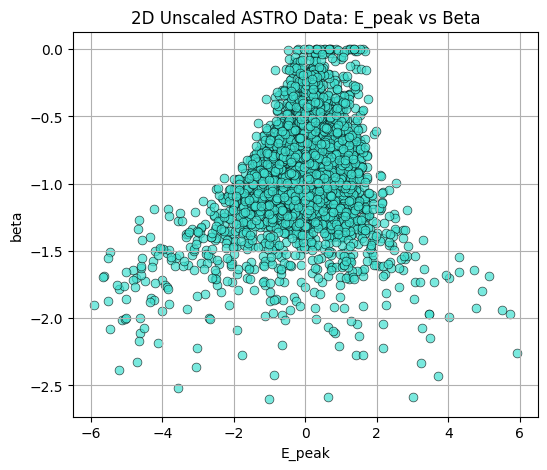

In [101]:
# Representación 2D
plt.figure(figsize=(6, 5))

sns.scatterplot(
    data=df_astro,
    x="E_peak",
    y="beta",
    color="turquoise",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("2D Unscaled ASTRO Data: E_peak vs Beta")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.show()

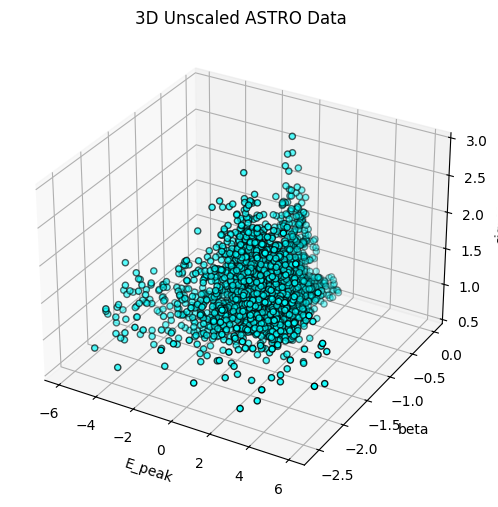

In [102]:
# Representación 3D
x = df_astro['E_peak']
y = df_astro['beta']
z = df_astro['sigma']

labels = df_astro['class']

# Plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=labels, cmap='cool', edgecolor='k')

ax.set_xlabel('E_peak')
ax.set_ylabel('beta')
ax.set_zlabel('sigma')
plt.title('3D Unscaled ASTRO Data')
plt.show()


# UNIDs

In [103]:
unids_path = "../../data/raw/unids_3F_beta_err_names.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')
df_unids.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,2.51290,0.0897,7.3996,1.630992,0
1,1.47820,0.4163,5.4150,0.770838,1
2,1.59640,0.6783,10.7909,0.371222,2
3,0.93095,0.2771,7.6056,0.628654,3
4,0.44480,0.3207,4.2748,0.567509,4


In [104]:
# convertimos a logaritmo
cols_to_log = ["E_peak", "beta", "sigma_det", "beta_Rel"]
df_unids_log = df_unids.copy()
df_unids_log[cols_to_log] = df_unids_log[cols_to_log].apply(lambda x: np.log10(x.clip(lower=1e-10)))

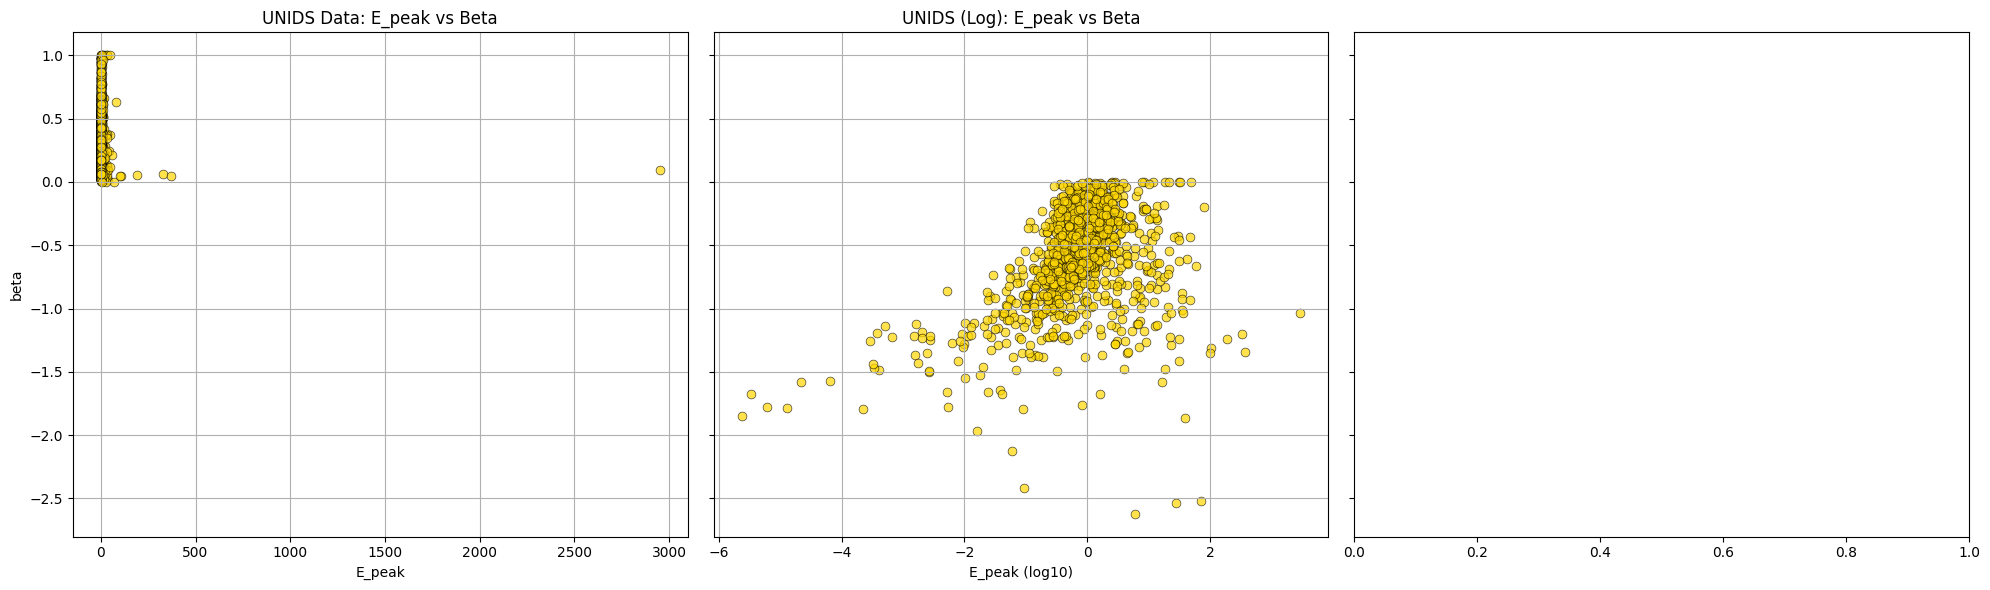

In [105]:
# --- Create subplots ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# --- Plot 1: Raw UNIDS data ---
sns.scatterplot(
    data=df_unids,
    x="E_peak",
    y="beta",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[0]
)
axes[0].set_title("UNIDS Data: E_peak vs Beta")
axes[0].set_xlabel("E_peak")
axes[0].set_ylabel("beta")
axes[0].grid(True)

# --- Plot 2: Log-transformed UNIDS ---
sns.scatterplot(
    data=df_unids_log,
    x="E_peak",
    y="beta",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[1]
)
axes[1].set_title("UNIDS (Log): E_peak vs Beta")
axes[1].set_xlabel("E_peak (log10)")
axes[1].set_ylabel("")  # hide repeated ylabel
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Entrenar modelo con X iteraciones

El random_state está fijado (controlado) con valores fijos: random_state=42+i y random_state=99+i

Cada iteración use la misma semilla de aleatoriedad y, por tanto, las mismas divisiones de datos →
→ mismos splits → mismos datos de entrenamiento y validación → mismos resultados.


🔄 Iteración 1/5
✅ Iter 1: nu=0.005, gamma=0.001, F1=0.9938


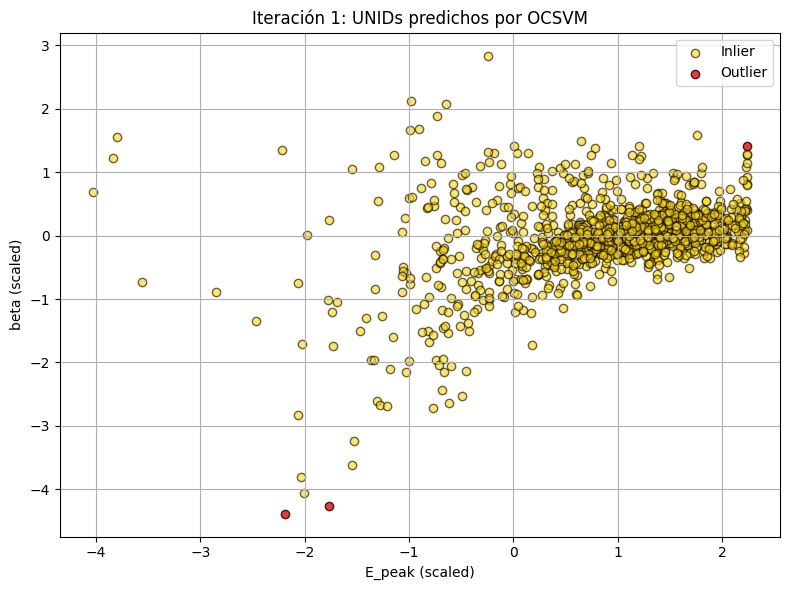

📝 Iteración 1: 3 anomalías detectadas. Top IDs: [1109, 117, 1017]

🔄 Iteración 2/5
✅ Iter 2: nu=0.005, gamma=0.1, F1=0.9956


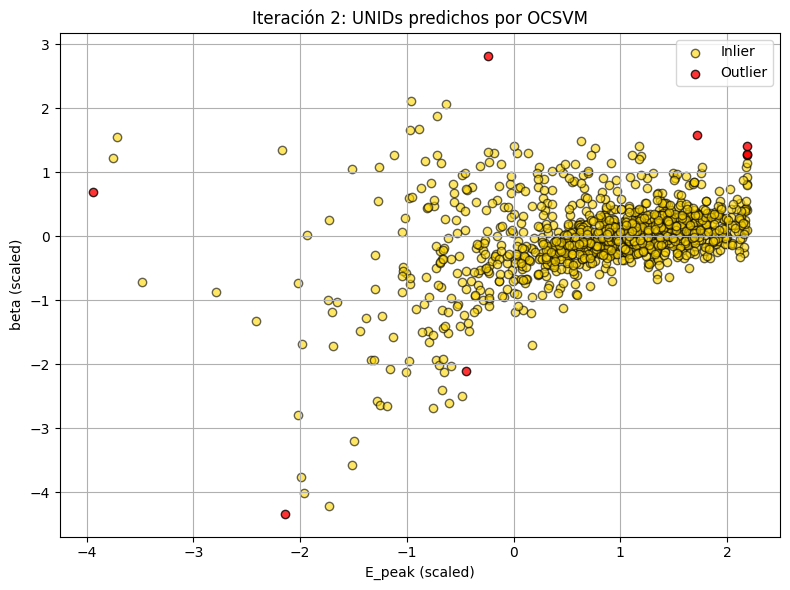

📝 Iteración 2: 8 anomalías detectadas. Top IDs: [1116, 1054, 1017, 307, 1080, 287, 1109, 240]

🔄 Iteración 3/5
✅ Iter 3: nu=0.005, gamma=0.001, F1=0.9947


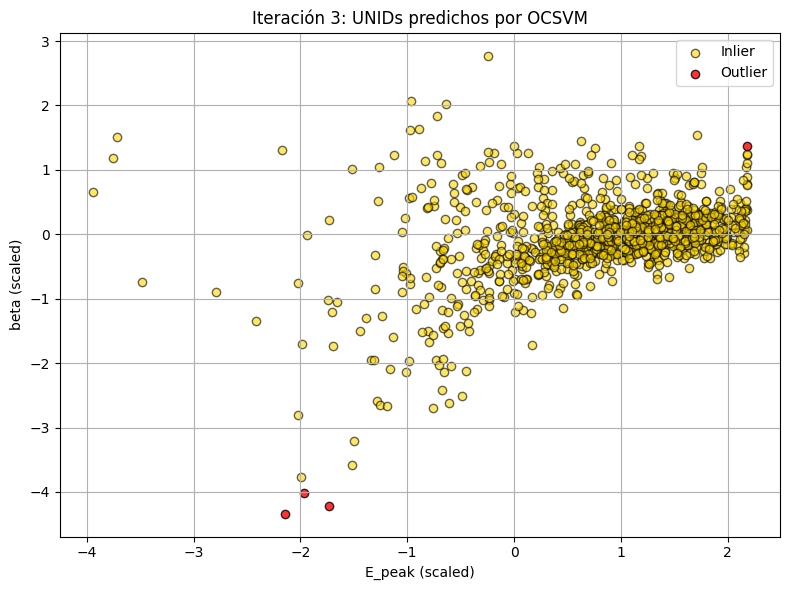

📝 Iteración 3: 4 anomalías detectadas. Top IDs: [1109, 117, 513, 1017]

🔄 Iteración 4/5
✅ Iter 4: nu=0.005, gamma=0.001, F1=0.9938


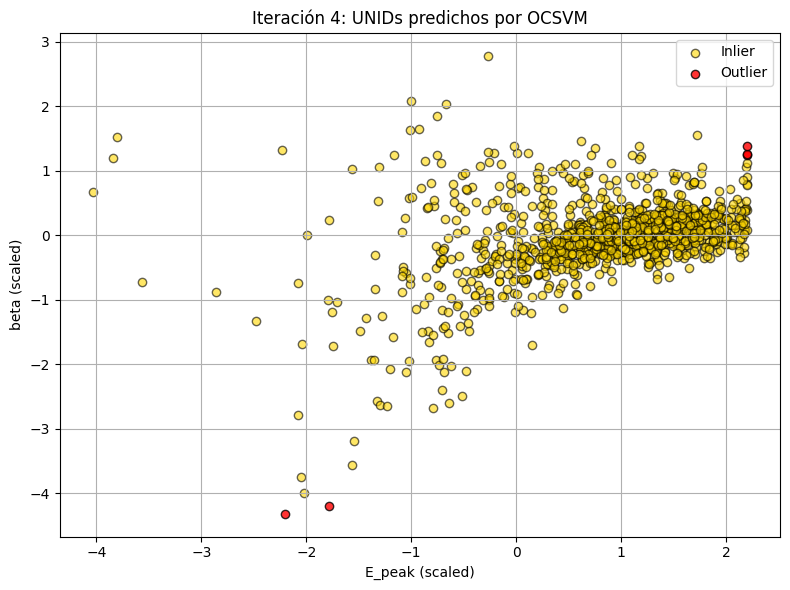

📝 Iteración 4: 5 anomalías detectadas. Top IDs: [1109, 1017, 307, 240, 117]

🔄 Iteración 5/5
✅ Iter 5: nu=0.005, gamma=0.001, F1=0.9991


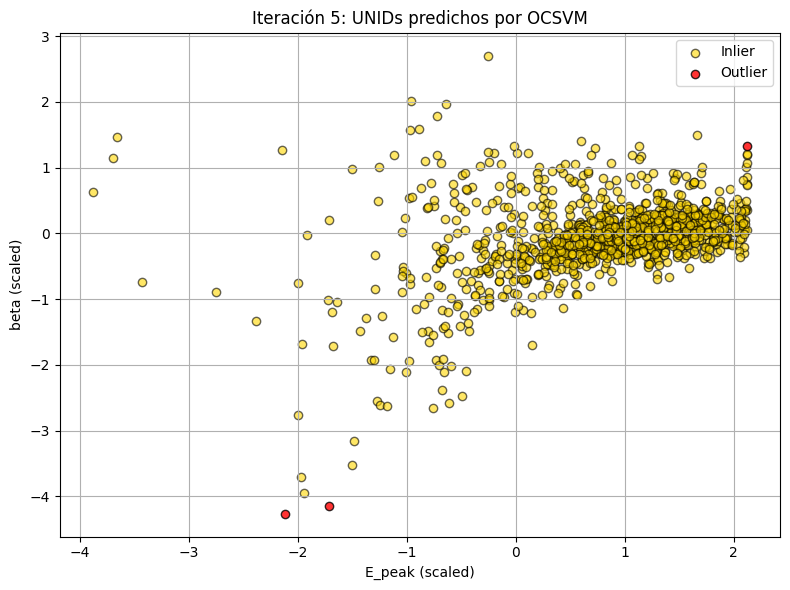

📝 Iteración 5: 3 anomalías detectadas. Top IDs: [1109, 1017, 117]


,iter,nu,gamma,f1_score
115,5,0.005,0.01,0.999116
114,5,0.005,0.001,0.999116
116,5,0.005,0.1,0.998230
123,5,0.010,0.1,0.998230
122,5,0.010,0.01,0.998230
...,...,...,...,...
76,3,0.020,10.0,0.548718
34,2,0.005,10.0,0.544987
118,5,0.005,10.0,0.541237
97,4,0.010,10.0,0.537468


,iter,top_unids_ids
0,1,"[1109, 117, 1017]"
1,2,"[1116, 1054, 1017, 307, 1080, 287, 1109, 240]"
2,3,"[1109, 117, 513, 1017]"
3,4,"[1109, 1017, 307, 240, 117]"
4,5,"[1109, 1017, 117]"


In [ ]:
"""
El random_state está fijado (controlado) con valores fijos: random_state=42+i y random_state=99+i

Cada iteración use la misma semilla de aleatoriedad y, por tanto, las mismas divisiones de datos 
→ mismos splits → mismos datos de entrenamiento y validación → mismos resultados."""

n_iterations = 5

all_iterations_results = []
best_models = []
all_top_unids_ids = []  # aquí guardaremos los IDs top anómalos de cada iteración

for i in range(n_iterations):
    print(f"\n🔄 Iteración {i+1}/{n_iterations}")

    # === 1️⃣ Split dinámico
    X = df_astro[features].values
    y = df_astro["class"].values

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=42 + i
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=99 + i
    )

    # === 2️⃣ Escalado
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # === 3️⃣ Grid search
    nu_values = [0.005, 0.01, 0.02, 0.05]
    gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))

    best_score = 0.0
    best_model_iter = None
    best_params_iter = {}
    iteration_results = []

    for nu in nu_values:
        for gamma in gamma_values:
            model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
            model.fit(X_train_scaled)

            preds = model.predict(X_val_scaled)
            pred_labels = np.where(preds == 1, 0, 1)
            true_labels = y_val.astype(int)

            f1 = f1_score(true_labels, pred_labels, pos_label=0)

            iteration_results.append({'nu': nu, 'gamma': gamma, 'f1_score': f1})

            if f1 > best_score:
                best_score = f1
                best_model_iter = model
                best_params_iter = {'nu': nu, 'gamma': gamma}

    print(f"✅ Iter {i+1}: nu={best_params_iter['nu']}, gamma={best_params_iter['gamma']}, F1={best_score:.4f}")
    all_iterations_results.extend([dict(iter=i+1, **res) for res in iteration_results])
    best_models.append(best_model_iter)

    # === 4️⃣ PREDECIR SOBRE UNIDs usando best_model_iter
    # (asumiendo que tienes ya df_unids_log preparado previamente)

    # Transformar UNIDs con el escalador de esta iteración
    X_unids_log = df_unids_log[["E_peak", "beta", "sigma_det"]].values
    X_unids_scaled = scaler.transform(X_unids_log)

    # Predicciones
    unids_preds = best_model_iter.predict(X_unids_scaled)
    decision_scores = best_model_iter.decision_function(X_unids_scaled)

    # Separar inliers y outliers
    inliers = X_unids_scaled[unids_preds == 1]
    outliers = X_unids_scaled[unids_preds == -1]

    # === 🎨 SCATTER PLOT DE PREDICCIONES ===
    plt.figure(figsize=(8,6))
    plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolor='k', label='Inlier', alpha=0.6)
    plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolor='k', label='Outlier', alpha=0.8)
    plt.title(f"Iteración {i+1}: UNIDs predichos por OCSVM")
    plt.xlabel("E_peak (scaled)")
    plt.ylabel("beta (scaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    anom_scores = -decision_scores
    anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(anom_scores.reshape(-1, 1)).flatten()

    # Añadir columnas al dataframe
    df_unids_log[f"svm_score_iter_{i+1}"] = decision_scores
    df_unids_log[f"Anomaly_Score_iter_{i+1}"] = anom_scores
    df_unids_log[f"Anomaly_Rank(%)_iter_{i+1}"] = anom_percent
    df_unids_log[f"prediction_iter_{i+1}"] = unids_preds

    # Obtener top anomalías
    top_anomalies = df_unids_log[df_unids_log[f"prediction_iter_{i+1}"] == -1].sort_values(by=f"Anomaly_Rank(%)_iter_{i+1}", ascending=False).head(10)

    # Guardar los IDs top anomalías
    top_ids = top_anomalies['number'].tolist()
    all_top_unids_ids.append({'iter': i+1, 'top_unids_ids': top_ids})

    print(f"📝 Iteración {i+1}: {len(top_ids)} anomalías detectadas. Top IDs: {top_ids}")

# === 5️⃣ Convertir resultados
df_all_results = pd.DataFrame(all_iterations_results)
df_all_top_ids = pd.DataFrame(all_top_unids_ids)

# Mostrar resumen
display(df_all_results.sort_values(by='f1_score', ascending=False))
display(df_all_top_ids)


In [107]:
for i, model in enumerate(best_models):
    test_preds = model.predict(X_test_scaled)
    test_labels = np.where(test_preds == 1, 0, 1)
    print(f"\n📝 Iteración {i+1}")
    print(confusion_matrix(y_test, test_labels))
    print(classification_report(y_test, test_labels, target_names=['Normal', 'Anomalía']))


📝 Iteración 1
[[565   2]
 [  0   0]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       567
    Anomalía       0.00      0.00      0.00         0

    accuracy                           1.00       567
   macro avg       0.50      0.50      0.50       567
weighted avg       1.00      1.00      1.00       567


📝 Iteración 2
[[566   1]
 [  0   0]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       567
    Anomalía       0.00      0.00      0.00         0

    accuracy                           1.00       567
   macro avg       0.50      0.50      0.50       567
weighted avg       1.00      1.00      1.00       567


📝 Iteración 3
[[565   2]
 [  0   0]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       567
    Anomalía       0.00      0.00      0.00         0

    accuracy                           1.00       567
   macro avg  

/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [108]:
# Paso 1: identificar hiperparámetros globales
best_global = df_all_results.sort_values(by='f1_score', ascending=False).iloc[0]
print("Mejor combinación global:")
print(best_global)

# Paso 2: reentrenar con X_train + X_val
X_final_train = np.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

scaler_final = StandardScaler()
X_final_train_scaled = scaler_final.fit_transform(X_final_train)
X_test_scaled = scaler_final.transform(X_test)

# Paso 3: entrenar modelo final
final_model = OneClassSVM(kernel='rbf', nu=best_global['nu'], gamma=best_global['gamma'])
final_model.fit(X_final_train_scaled)

# Paso 4: evaluar en test
test_preds = final_model.predict(X_test_scaled)
test_labels = np.where(test_preds == 1, 0, 1)

print(confusion_matrix(y_test, test_labels))
print(classification_report(y_test, test_labels, target_names=['Normal', 'Anomalía']))

Mejor combinación global:
iter               5
nu             0.005
gamma           0.01
f1_score    0.999116
Name: 115, dtype: object
[[566   1]
 [  0   0]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       567
    Anomalía       0.00      0.00      0.00         0

    accuracy                           1.00       567
   macro avg       0.50      0.50      0.50       567
weighted avg       1.00      1.00      1.00       567



/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m